In [32]:
from tools import *
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from extra import plot_directed_graph

In [33]:
graph4JSON="graphes_JSON_Complet/Graphe(1)_features.json"

edges= extract_mapped_edges_from_json(graph4JSON)
feature_matrix_df = extract_node_features_from_json_file(graph4JSON)
repartition=extract_optimal_repartition_from_json(graph4JSON)


In [34]:
edges

,from,to,original_from,original_to
0,0,2,5,2
1,0,4,5,7
2,0,5,5,4
3,1,4,6,7
4,1,5,6,4
5,2,3,2,3
6,2,4,2,7
7,2,5,2,4
8,4,5,7,4


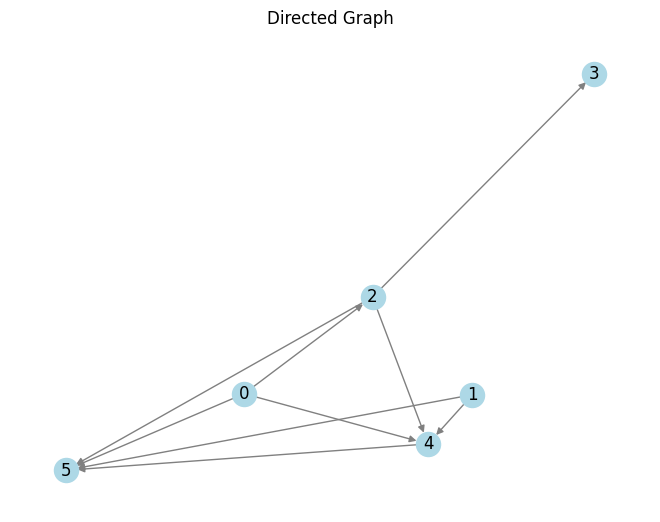

In [35]:
plot_directed_graph(edges["from"],edges["to"])


In [36]:
feature_matrix_df.head()

,fan_in,fan_out,depth,weight,cpu_speed,comm_speed,latency,computation_time,n_cpus
node_id,,,,,,,,,
5,1,3,2,2,4.77,8.52,0.690544,0.00314,55
6,2,2,2,4,4.77,8.52,0.690544,0.01256,55
2,2,3,3,4,4.77,8.52,0.690544,0.01256,55
3,1,0,4,2,4.77,8.52,0.690544,0.00314,55
7,4,1,4,16,4.77,8.52,0.690544,0.10048,55


In [37]:
edges

,from,to,original_from,original_to
0,0,2,5,2
1,0,4,5,7
2,0,5,5,4
3,1,4,6,7
4,1,5,6,4
5,2,3,2,3
6,2,4,2,7
7,2,5,2,4
8,4,5,7,4


In [38]:
repartition

,original_id,assigned_cpu,mapped_id
0,5,0,0
1,6,3,1
2,2,1,2
3,3,0,3
4,7,6,4
5,4,5,5


In [39]:
# edges
from_nodes=edges['from'].values
to_nodes=edges['to'].values
edge_index = np.array([from_nodes, to_nodes], dtype=np.int64)
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)

# x_train
features=feature_matrix_df.values
x = torch.tensor(features, dtype=torch.float32)

# y_train
y_target = repartition['assigned_cpu'].values
y = torch.tensor(y_target, dtype=torch.long)


data = Data(x=x, edge_index=edge_index_tensor, y=y)

In [40]:
data

Data(x=[6, 9], edge_index=[2, 9], y=[6])

In [41]:
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(in_channels=8, out_channels=32)  # 8 node features -> 32 hidden
        self.lin = torch.nn.Linear(32, 64)  # 64 classes (CPUs)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)  # Each node gathers info from 1-hop neighbors
        x = F.relu(x) 
        embeddings = x.clone()                  # Non-linearity
        x = self.lin(x)                # Final layer predicts a class between 0–63
        return x,embeddings

In [42]:
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [43]:
model

GNN(
  (conv1): GCNConv(8, 32)
  (lin): Linear(in_features=32, out_features=64, bias=True)
)

In [44]:
all_losses = []
all_accuracies = []
all_embeddings=[]

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out , embeddings= model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    
    _, pred = out.max(dim=1)
    correct = (pred == data.y).sum()
    acc = int(correct) / data.y.size(0)
    
    all_losses.append(loss.item())
    all_accuracies.append(acc)
    all_embeddings.append(embeddings)
    
    if epoch % 100 == 9 or epoch == 0:  
        print(f"Epoch {epoch+1:2d}: Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x9 and 8x32)

In [ ]:
y_pred,embeddings= model(data)
predicted_classes = y_pred.argmax(dim=1)



In [ ]:
pred_np = predicted_classes.cpu().numpy()
actual_np = data.y.cpu().numpy()

predicitons_df = pd.DataFrame({
    'Actual': actual_np,
    'Predicted': pred_np
})

In [ ]:
predicitons_df

,Actual,Predicted
0,15,9
1,16,9
2,22,23
3,23,4
4,4,4
...,...,...
130,25,25
131,6,7
132,7,7
133,10,10
